# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#!conda remove -y numpy
#!conda install -y -c anaconda numpy
#!conda install -y  -c anaconda matplotlib
!conda install -y  -c anaconda seaborn=0.9.0

import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn=0.9.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  anaconda
    ca-certificates-2019.5.15  |                1         134 KB  anaconda
    certifi-2019.6.16          |           py36_1         156 KB  anaconda
    openssl-1.0.2t             |       h7b6447c_1         3.1 MB  anaconda
    seaborn-0.9.0              |           py36_0         379 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following NEW packages will be INSTALLED:

  

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')
df.persist()
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [3]:
df.count()

286500

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#df.select('page').distinct().show(100)

In [6]:
df_nulls = df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [7]:
df.filter(df.registration.isNull()).select("userId").distinct().show()

+------+
|userId|
+------+
|      |
+------+



In [8]:
df.filter(df.registration.isNull()).show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [9]:
df.filter(df.userId == "").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [10]:
df.filter(df.userId == "").count()

8346

It seems that the daat where user id is blank , we also get null registration value.We can discard these values.

In [11]:
df = df.filter(df.userId != "")
df.count()

278154

In [12]:
df = df.dropna(how ="any", subset =["userId", "sessionId"])
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



In [13]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
df.select("userId").distinct().count()

225

In [15]:
df.filter(df.page=="Cancellation Confirmation").select("userId").distinct().show(50)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
|300001|
|100009|
|100015|
|200024|
|100003|
|   103|
|100024|
|    53|
|   122|
|200017|
|    58|
|100011|
|100019|
|100012|
|200018|
|200016|
|200020|
|   106|
|   143|
|    32|
|200001|
|   105|
|200011|
|100023|
|100013|
|100017|
|   121|
|    12|
|200015|
|   129|
+------+
only showing top 50 rows



In [16]:
df.filter(df.page=="Cancellation Confirmation").select("userId").distinct().count()

52

In [17]:
df.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



In [18]:
event_counts = df.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')
event_counts

,count
page,
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Logout,3226
Thumbs Down,2546
Downgrade,2055


As expected the NextSong page is the most frequent and the Downgrade, Cancellation Confirmation,Register pages happen less frequently.

In [19]:
df.filter(df.page=="Cancellation Confirmation").select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [20]:
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = sf.udf(convert_ms, st.LongType())

df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))

df.select('ts', 'timestamp', 'registration', 'registration_ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|          timestamp| registration|    registration_ts|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|1538173362000|2018-09-28 22:22:42|
|1538352180000|2018-10-01 00:03:00|1538331630000|2018-09-30 18:20:30|
|1538352394000|2018-10-01 00:06:34|1538173362000|2018-09-28 22:22:42|
|1538352416000|2018-10-01 00:06:56|1538331630000|2018-09-30 18:20:30|
|1538352676000|2018-10-01 00:11:16|1538173362000|2018-09-28 22:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [21]:
df.where(df.page=='Cancellation Confirmation').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|          timestamp|    registration_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 20:26:30|2018-08-30 10:04:26|
|  null|Cancelled|    Diego|     M|         

In [22]:
df.agg(sf.min('timestamp'), sf.max('timestamp')).show()
df.agg(sf.min('registration_ts'), sf.max('registration_ts')).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+

+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
| 2018-03-18 13:44:35| 2018-11-26 15:49:14|
+--------------------+--------------------+



In [23]:
def plot_time_counts(df, page=None, agg='day', by_field=None):
    """
    Function to aggregate by date and get the resulting counts. Displays the resulting line plot.
    
    Parameters:
        df (PySpark Dataframe): Input Dataframe
        page (str): Optional, input an event to limit the count to just that event
        agg (str): Optional, input a date or time trunc type to change the granularity
        by_field (str)): Optional, input a field to aggregate by that too
        
    Returns:
        None
    """
    if page is not None:
        plot_df = df.where(df.page==page)
    else:
        plot_df = df
    
    if by_field is None:
        group = sf.date_trunc(agg, plot_df.timestamp).alias(agg)
    elif by_field is not None:
        group = [sf.date_trunc(agg, plot_df.timestamp).alias(agg), by_field]
        
    daily_counts = plot_df.groupby(group).count().sort(agg).toPandas()
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x=agg, 
                 y='count', 
                hue=by_field, 
                data=daily_counts)


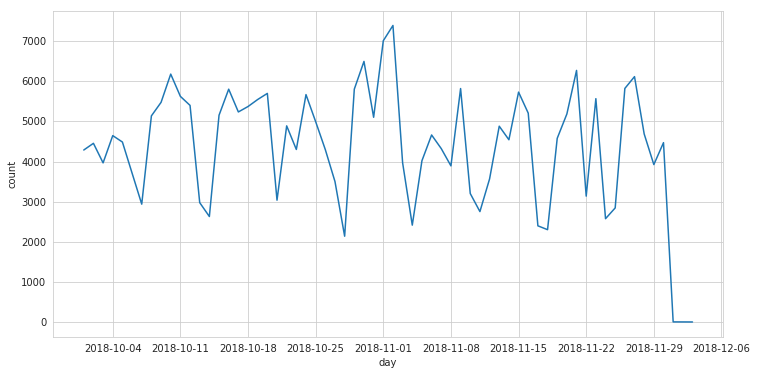

In [24]:
plot_time_counts(df)

In [25]:
def plot_field_count_dist(df, field, page=None):
    """
    Plots the distribution of a given field
    
    Arguments:
        df (Spark DataFrame): the input dataframe
        field (str): The field to graph the distribution of
        page (str): Optional, limits the distribution to a single page
    """
    if page is not None:
        plot_df = df.where(df.page==page)
    else:
        plot_df = df
    
    field_counts = plot_df.groupby(field).count().toPandas()
    
    sns.distplot(field_counts['count'], 
                 kde=False, 
                 bins=20)
    


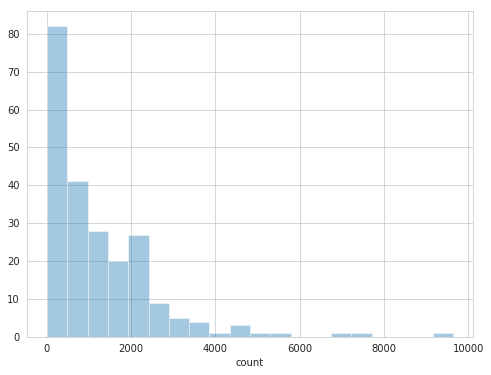

In [26]:
plt.figure(figsize=(8,6))
plot_field_count_dist(df, 'userId')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:
df.where(df.page=='Cancellation Confirmation').select(['page', 'timestamp', 'userId', 'sessionId', 'level', 'registration_ts']).show(10)

+--------------------+-------------------+------+---------+-----+-------------------+
|                page|          timestamp|userId|sessionId|level|    registration_ts|
+--------------------+-------------------+------+---------+-----+-------------------+
|Cancellation Conf...|2018-10-07 20:26:30|    18|      514| paid|2018-08-30 10:04:26|
|Cancellation Conf...|2018-10-08 21:10:46|    32|      540| paid|2018-09-17 06:59:53|
|Cancellation Conf...|2018-10-12 04:35:18|   125|      174| free|2018-08-01 20:58:59|
|Cancellation Conf...|2018-10-12 20:17:21|   105|      508| paid|2018-09-13 05:43:01|
|Cancellation Conf...|2018-10-13 21:19:44|    17|      797| paid|2018-09-30 18:57:09|
|Cancellation Conf...|2018-10-15 07:34:14|   143|      843| free|2018-08-14 13:58:33|
|Cancellation Conf...|2018-10-16 22:30:37|   101|      842| paid|2018-08-23 23:19:40|
|Cancellation Conf...|2018-10-17 00:29:21|   129|      802| paid|2018-09-30 06:42:56|
|Cancellation Conf...|2018-10-17 07:02:29|   121|     

In [28]:
df.where((df.userId==32) &
         (df.timestamp>'2018-10-08 19:10:46')).sort('ts').select('timestamp', 'page','sessionId', 'level', 'registration_ts').show(100)

+-------------------+--------------------+---------+-----+-------------------+
|          timestamp|                page|sessionId|level|    registration_ts|
+-------------------+--------------------+---------+-----+-------------------+
|2018-10-08 19:13:53|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:16:54|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:21:23|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:24:48|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:28:26|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:33:22|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:37:28|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:40:52|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:46:49|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:52:31|            NextSong|      540|

A common observation is that user's accessing Cancellation Confirmation page do not have any further records, which seems to be logical.

In [29]:
churn_users = df.where(df.page=='Cancellation Confirmation').select('userId').toPandas().userId.tolist()

df = df.withColumn('churn', df.userId.isin(churn_users))
df.select('page', 'timestamp', 'userId', 'sessionId', 'level', 'churn').show(5)

+--------+-------------------+------+---------+-----+-----+
|    page|          timestamp|userId|sessionId|level|churn|
+--------+-------------------+------+---------+-----+-----+
|NextSong|2018-10-01 00:01:57|    30|       29| paid|false|
|NextSong|2018-10-01 00:03:00|     9|        8| free|false|
|NextSong|2018-10-01 00:06:34|    30|       29| paid|false|
|NextSong|2018-10-01 00:06:56|     9|        8| free|false|
|NextSong|2018-10-01 00:11:16|    30|       29| paid|false|
+--------+-------------------+------+---------+-----+-----+
only showing top 5 rows



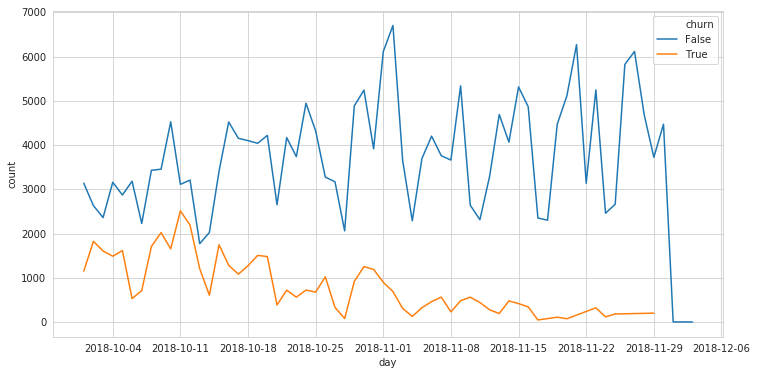

In [30]:
plot_time_counts(df, by_field='churn')

We see that non-churn users get more engaged with the product, while churn users show  a drop in engagement.Which is a noticeable feature of a user who may opt out in some time.

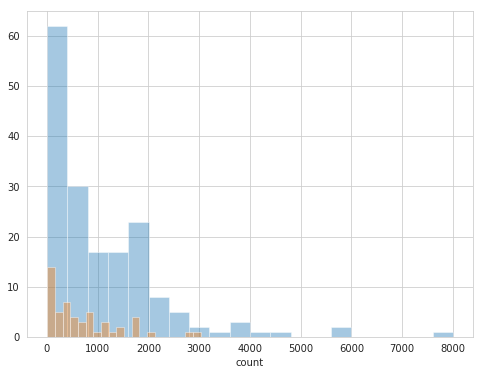

In [31]:
plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'userId', page='NextSong')
plot_field_count_dist(df.where(df.churn), 'userId', page='NextSong')

We can see clearly that churn users do not go through lot of songs as compared to other users.

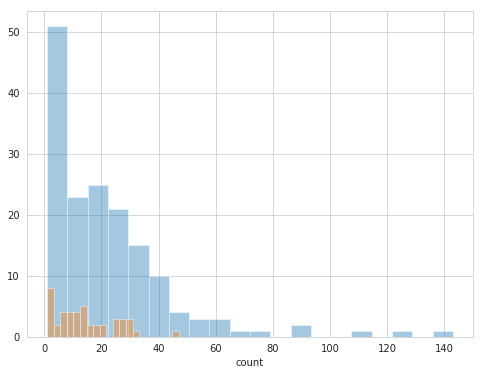

In [32]:
plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'userId', page='Add Friend')
plot_field_count_dist(df.where(df.churn), 'userId', page='Add Friend')

We see a remarkable difference between users who churn out and others.The churn users tend to add way more friends, giving a hint of user traits who might churn away.

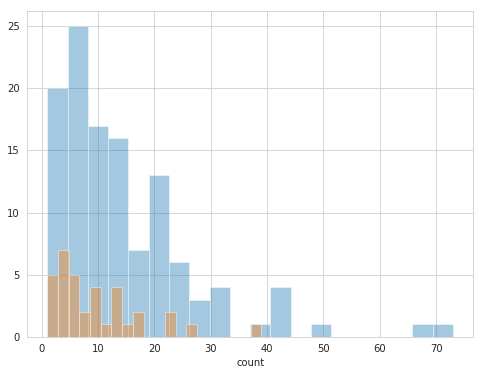

In [33]:
plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'userId', page='Downgrade')
plot_field_count_dist(df.where(df.churn), 'userId', page='Downgrade')

More number of downgrades suggest user is likely to stay, which is indicative of the fact that user engagement is on.

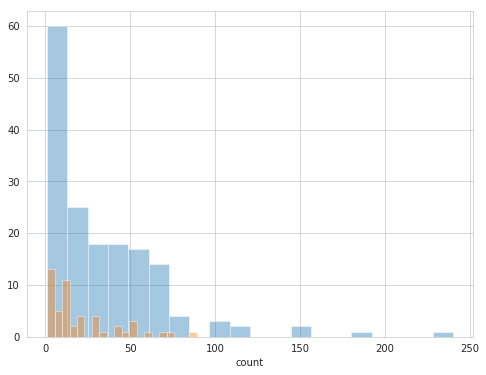

In [34]:

plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'userId', page='Add to Playlist')
plot_field_count_dist(df.where(df.churn), 'userId', page='Add to Playlist')

More playlists suggest thaht users are going to continue.

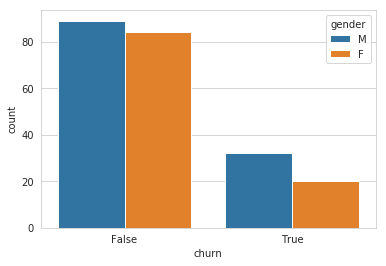

In [35]:
df_pd = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

Male users tend to churn more than female users.

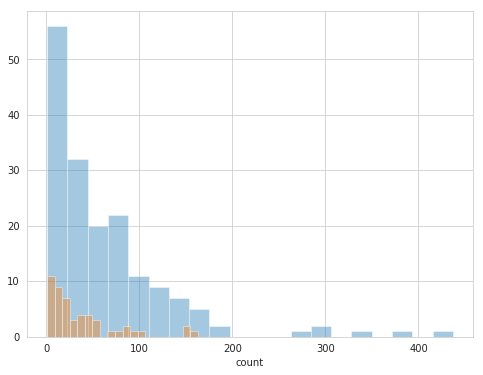

In [36]:

plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'userId', page='Thumbs Up')
plot_field_count_dist(df.where(df.churn), 'userId', page='Thumbs Up')

More thumbs up suggest users are happy and engaged and less churn.

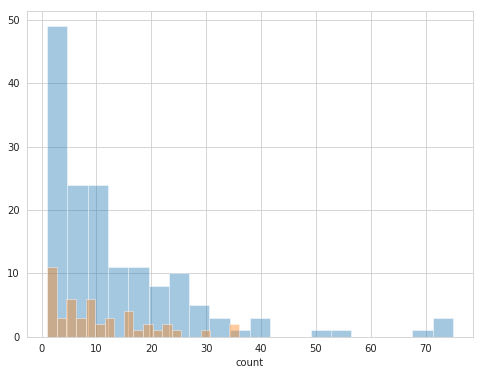

In [37]:
plt.figure(figsize=(8, 6))
no_churn_song_counts = plot_field_count_dist(df.where(~df.churn), 'userId', page='Thumbs Down')
churn_song_counts = plot_field_count_dist(df.where(df.churn), 'userId', page='Thumbs Down')

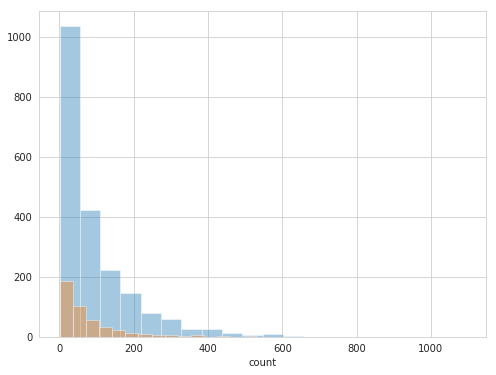

In [38]:
plt.figure(figsize=(8, 6))
plot_field_count_dist(df.where(~df.churn), 'sessionId', page='NextSong')
plot_field_count_dist(df.where(df.churn), 'sessionId', page='NextSong')

more number of songs played by non-churn users as exepcted.

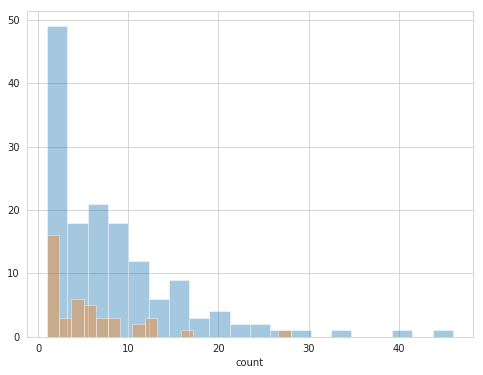

In [39]:
plt.figure(figsize=(8, 6))
no_churn_song_counts = plot_field_count_dist(df.where(~df.churn), 'userId', page='Help')
churn_song_counts = plot_field_count_dist(df.where(df.churn), 'userId', page='Help')

More help pages suggest users are trying to engage more and hence less churn.

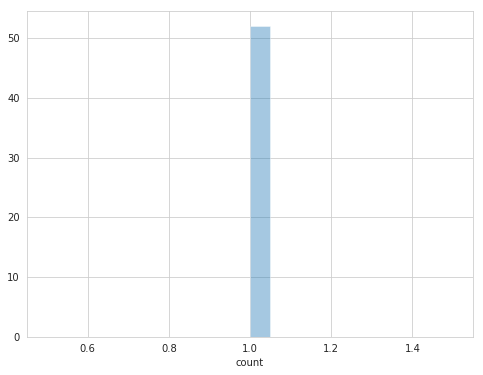

In [40]:
plt.figure(figsize=(8, 6))
#no_churn_song_counts = plot_field_count_dist(df.where(~df.churn), 'userId', page='Cancel')
churn_song_counts = plot_field_count_dist(df.where(df.churn), 'userId', page='Cancel')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [41]:
def feature_engineering(df):
    '''
    Create necessary features to use machine learning algorithms.
    First loads data set from file
    
    Resulting DF Strucutre:
    
    root
     |-- userId: string
     |-- downgraded: long
     |-- cancelled: long
     |-- visited_cancel: long
     |-- visited_downgrade: long
     |-- dailyHelpVisits: double
     |-- dailyErrors: double
     |-- free: integer
     |-- paid: integer
     |-- avgThumbsUp: double
     |-- avgThumbsDOwn: double
     |-- numFriends: long
     |-- avgSongsTillHome: double
     |-- avgTimeSkipped: double
     |-- skipRate: double
    
    Inputs
        df - infput dataframe
        
    Outputs
        data - engineered dataset
    '''

    
    df = df.dropna(how ="any", subset =["userId", "sessionId"])
    users = df.select('userId').dropDuplicates()
    
    #define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())

    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())

    song = udf(lambda x: int(x=='NextSong'), IntegerType())
    days = lambda i: i * 86400 
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    skipped = udf(lambda x: int(x!=0), IntegerType())
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())
    
    #define windows
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
    daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts'))\
        .rangeBetween(Window.unboundedPreceding, 0)

    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')
    

    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    '''
    process for calculating skipping variables

    1. dont include thumbs up and down pages because that usually occurs 
        while playing and does not change song
    2. create variable for if action is song
    3. check if next action is song - this will check to see if someone is 
        skipping song or just leaving page
    4. get the difference in timestamp for next action song playing
    5. subtract the difference in timestamp from song length to see 
        how much of song was skipped
    6. get descriptive stats
    '''

    skipping = df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
        .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
        .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
        .withColumn('nextActSong', lag(col('song')).over(session))\
        .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
        .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
        .withColumn('roundedLength', floor('length'))\
        .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
        .withColumn('skipped', skipped('timeSkipped'))\
        .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
        .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
        .withColumnRenamed('avg(skipped)', 'skipRate')\
        .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')
    
#avg daily visits to help site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    dailyErrors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')
    
    #whether a user has downgraded
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    user_level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
    avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')
    
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(dailyErrors, on='userId')\
        .join(user_level, on='userId')\
        .join(avgThumbsUp, on='userId')\
        .join(avgThumbsDown, on='userId')\
        .join(numFriends, on='userId')\
        .join(avgSongsTillHome, on='userId')\
        .join(skipping, on='userId')
    
    return df

In [42]:
pages = df.select('page').distinct().sort('page')
pages.show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [43]:
pages_list = [r.page for r in pages.collect()]
pages_list

['About',
 'Add Friend',
 'Add to Playlist',
 'Cancel',
 'Cancellation Confirmation',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

In [44]:
feat_df = df.groupby('userId').pivot('page', pages_list).count().sort('userId')
feat_df.show(3)

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    10|    2|        12|              9|  null|                     null|        7| null|   1|  30|    11|     673|          1|            1|       7|            null|          null|          4|       37|   null|
|   100|   12|        49|             61|  null|                     null|       30|    3|  18| 105|    35|    2682|         25|            5|  

In [45]:
feat_df = feat_df.withColumnRenamed('Cancellation Confirmation', 'churn')
feat_df = feat_df.drop('Cancel').fillna(0)
feat_df.show(3)

+------+-----+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|churn|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    10|    2|        12|              9|    0|        7|    0|   1|  30|    11|     673|          1|            1|       7|               0|             0|          4|       37|      0|
|   100|   12|        49|             61|    0|       30|    3|  18| 105|    35|    2682|         25|            5|      11|               1|             1|         27|      148|      1|
|100001|    0|         2|              3|    1|        0|    1|  

In [46]:
session_counts = df.groupby('userId').agg(sf.countDistinct('sessionId').alias('session_count'))
session_counts.show(3)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            7|
|200002|            6|
|   125|            1|
+------+-------------+
only showing top 3 rows



In [47]:
genders = df.select('userId', sf.when(sf.col('gender')=='F', 0).otherwise(1).alias('genders')).distinct().sort('userId')
genders.show()
feat_df = feat_df.join(genders, on='userId')
feat_df.show(3)

+------+-------+
|userId|genders|
+------+-------+
|    10|      1|
|   100|      1|
|100001|      0|
|100002|      0|
|100003|      0|
|100004|      0|
|100005|      1|
|100006|      0|
|100007|      0|
|100008|      0|
|100009|      1|
|100010|      0|
|100011|      1|
|100012|      1|
|100013|      0|
|100014|      1|
|100015|      0|
|100016|      1|
|100017|      1|
|100018|      1|
+------+-------+
only showing top 20 rows

+------+-----+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-------+
|userId|About|Add Friend|Add to Playlist|churn|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|genders|
+------+-----+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+--------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.